# 데이터 준비

In [9]:
import pandas as pd

df = pd.read_excel('data/train_data.xlsx',sheet_name = 'train_data_비오는날제거')

In [10]:
input_data = (df[['illum1','illum2','illum3','azimuth_180_diff','elevation']]).to_numpy()
print(input_data)

[[ 69.21  67.49  74.46  77.35  22.05]
 [ 69.21  67.49  74.46  77.32  22.08]
 [ 70.07  67.49  74.46  77.29  22.11]
 ...
 [ 21.86  17.66  18.04 112.79   8.68]
 [ 23.58  18.52  19.68 112.92   8.5 ]
 [ 24.44  19.38  20.5  113.06   8.32]]


In [11]:
target_data = (df[['illum4','illum5','illum6','illum7','illum8','illum9']]).to_numpy()

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(input_data)
normalized_features = scaler.transform(input_data)

# 모델 생성

In [13]:
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer = 'adam'):
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', input_shape=(5,)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(6, activation='relu'))
    model.compile(optimizer = optimizer,loss='mae',metrics='accuracy')
    model.summary()
    return model

In [14]:
# model = KerasRegressor(build_fn=create_model, verbose=0)
model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                384       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 4,934
Trainable params: 4,934
Non-trainable params: 0
_________________________________________________________________


In [15]:
# param_grid = {
#     'batch_size': [32, 64],
#     'epochs': [100, 200],
#     'optimizer': ['adam', 'rmsprop']
# }

In [16]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# 그리드서치
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# 조기 종료
early_stopping_cb = keras.callbacks.EarlyStopping(patience =10, restore_best_weights =True, monitor = 'val_loss')
checkpoint_cb = ModelCheckpoint("best_model_dense3.h5", monitor='val_loss', save_best_only=True, mode='min')

In [17]:
x_train = normalized_features
y_train = target_data
validation_split = 0.2  # Adjust the validation split ratio as per your preference
validation_size = int(len(x_train) * validation_split)
x_val = x_train[-validation_size:]
y_val = y_train[-validation_size:]
x_train = x_train[:-validation_size]
y_train = y_train[:-validation_size]

# 모델 훈련

In [18]:
# grid_search.fit(x_train, y_train, callbacks=[early_stopping_cb,checkpoint_cb],validation_data=(x_val, y_val))

# print("최적의 하이퍼파라미터: ", grid_search.best_params_)
# print("최고 점수: ", grid_search.best_score_)
# best_model = grid_search.best_estimator_
# best_model.save("sensoless_illum123_az_el_best_model.h5")


history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_data = (x_val, y_val), callbacks=[early_stopping_cb,checkpoint_cb])
# history = model.fit(x_train, y_train, epochs=100, batch_size=4)

Epoch 1/100
10976/10976 [==============================] - 13s 1ms/step - loss: 4.7450 - accuracy: 0.9518 - val_loss: 2.4678 - val_accuracy: 0.9322
Epoch 2/100
10976/10976 [==============================] - 12s 1ms/step - loss: 2.7755 - accuracy: 0.9785 - val_loss: 2.9170 - val_accuracy: 0.9267
Epoch 3/100
10976/10976 [==============================] - 12s 1ms/step - loss: 2.6135 - accuracy: 0.9878 - val_loss: 2.9667 - val_accuracy: 0.9264
Epoch 4/100
10976/10976 [==============================] - 12s 1ms/step - loss: 2.4408 - accuracy: 0.9890 - val_loss: 2.4320 - val_accuracy: 0.9112
Epoch 5/100
10976/10976 [==============================] - 12s 1ms/step - loss: 2.2209 - accuracy: 0.9851 - val_loss: 2.2286 - val_accuracy: 0.9400
Epoch 6/100
10976/10976 [==============================] - 12s 1ms/step - loss: 2.1014 - accuracy: 0.9861 - val_loss: 2.4286 - val_accuracy: 0.8910
Epoch 7/100
10976/10976 [==============================] - 12s 1ms/step - loss: 2.0437 - accuracy: 0.9879 - val_

In [19]:
model.save("sensorless_dnn_dense3.h5")

In [25]:
df_0412 = pd.read_excel('data/train_data.xlsx',sheet_name = 'test_data_0412')
input_0412 = (df_0412[['illum1','illum2','illum3','azimuth_180_diff','elevation']]).to_numpy()
output_0412 = (df_0412[['illum4','illum5','illum6','illum7','illum8','illum9']]).to_numpy()
datetime_0412 = (df_0412[['Datetime']])
normalized_features = scaler.transform(input_0412)
predict=model.predict(normalized_features)

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
RMSE = np.sqrt(mean_squared_error(output_0412, predict))
r2 = r2_score(output_0412, predict)
print(f'RMSE: {RMSE:.0f}')
print(f'r2:{r2:.4f}')
MAE = mean_absolute_error(output_0412, predict)
print(f'MAE:{MAE:.0f}')

135/135 [==============================] - 0s 696us/step
RMSE: 3
r2:0.9972
MAE:2


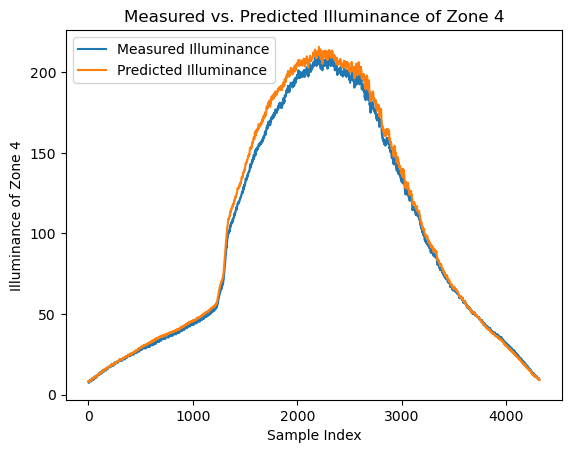

In [26]:

import matplotlib.pyplot as plt
measured_illum4 = output_0412[:, 0]  # Extracting zone 4 illuminance
predicted_illum4 = predict[:, 0]  # Extracting zone 4 illuminance predictions
x = range(len(measured_illum4))
import matplotlib.pyplot as plt

# Assuming 'output_0412' contains the measured illuminance values of zone 4
measured_illum4 = output_0412[:, 0]  # Extracting zone 4 illuminance

# Assuming 'predict' contains the predicted illuminance values
predicted_illum4 = predict[:, 0]  # Extracting zone 4 illuminance predictions

# Create x-axis values (e.g., indices or any other appropriate values)
x = range(len(measured_illum4))

# Plot measured and predicted illuminance of zone 4
plt.plot(x, measured_illum4, label='Measured Illuminance')
plt.plot(x, predicted_illum4, label='Predicted Illuminance')

# Add labels and title to the plot
plt.xlabel('Sample Index')
plt.ylabel('Illuminance of Zone 4')
plt.title('Measured vs. Predicted Illuminance of Zone 4')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [27]:
RMSE = np.sqrt(mean_squared_error(measured_illum4, predicted_illum4))
r2 = r2_score(output_0412, predict)
print(f'RMSE: {RMSE:.0f}')
print(f'r2:{r2:.4f}')
MAE = mean_absolute_error(output_0412, predict)
print(f'MAE:{MAE:.0f}')

RMSE: 5
r2:0.9972
MAE:2


In [23]:
# df_predict = pd.DataFrame(predict)
# df_illum = pd.DataFrame(output_0412)
# result = pd.concat([datetime,df_predict,df_illum], axis = 1)
# result.to_csv("data/0412_dnn_result.csv")

In [28]:
for i in range(6):
    RMSE = np.sqrt(mean_squared_error(measured_illum4, predicted_illum4))
    r2 = r2_score(output_0412[:, i], predict[:, i])
    print("----P",(i+4),"----")
    print(f'RMSE: {RMSE:.0f}')
    print(f'r2:{r2:.4f}')
    MAE = mean_absolute_error(output_0412[:, i], predict[:, i])
    print(f'MAE:{MAE:.0f}')

----P 4 ----
RMSE: 5
r2:0.9942
MAE:4
----P 5 ----
RMSE: 5
r2:0.9994
MAE:1
----P 6 ----
RMSE: 5
r2:0.9996
MAE:1
----P 7 ----
RMSE: 5
r2:0.9945
MAE:3
----P 8 ----
RMSE: 5
r2:0.9974
MAE:2
----P 9 ----
RMSE: 5
r2:0.9982
MAE:1
